In [1]:
from bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model
from data_preparation.movielens_100k import MovieLens100KData
from recommender import fit_recommendation_model, retrain_recommendation_model

### Prepare training data

In [2]:
data = MovieLens100KData(data_path='data/ml-100k')
X_train, X_val, X_test = data.get_data_splits_for_training()

### Train MF recommendation model

In [3]:
EMBEDDING_SIZE = 50
NUM_EPOCH = 20
REGULARIZATION = 1e-4

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 35us/sample - loss: 0.6921 - val_loss: 0.6750
Epoch 2/20
60000/60000 [==============================] - 2s 34us/sample - loss: 0.6615 - val_loss: 0.6542
Epoch 3/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.6454 - val_loss: 0.6433
Epoch 4/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.6363 - val_loss: 0.6374
Epoch 5/20
60000/60000 [==============================] - 2s 34us/sample - loss: 0.6306 - val_loss: 0.6334
Epoch 6/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.6272 - val_loss: 0.6313
Epoch 7/20
6000

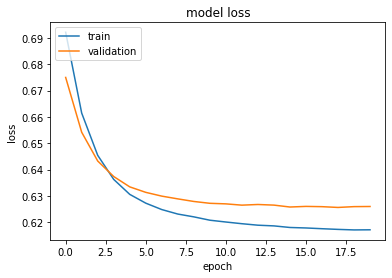

In [5]:
model = fit_recommendation_model(X_train, X_val, num_users=data.num_users, num_items=data.num_items, 
                                 epochs=NUM_EPOCH, embedding_size=EMBEDDING_SIZE, regularization_coef=REGULARIZATION)

### Analyze bias for the recommendation model

In [6]:
MIN_CHILD_NODE_SIZE = 1000
METRIC = 'absolute_error'

root=[]: 0.189
├── year_bucketized=['high', 'medium']: 0.193
│   ├── Thriller=[0]: 0.195
│   │   ├── year_bucketized=['high']: 0.209
│   │   └── year_bucketized=['medium']: 0.191
│   └── Thriller=[1]: 0.186
└── year_bucketized=['low']: 0.181
    ├── gender=['F']: 0.197
    └── gender=['M']: 0.176
        ├── Action=[0]: 0.178
        └── Action=[1]: 0.172



,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""year_bucketized"": [""low""], ""gender"": [""M""], ""Action"": [1]}",1414.0,0.171820,0.127884,0.000046,0.073612,0.150589,0.241801,0.874949
"{""year_bucketized"": [""low""], ""gender"": [""M""], ""Action"": [0]}",3787.0,0.177650,0.137059,0.000171,0.068730,0.157655,0.252606,0.853011
"{""year_bucketized"": [""high"", ""medium""], ""Thriller"": [1]}",3259.0,0.186134,0.142076,0.000044,0.075793,0.157385,0.262562,0.869039
"{""year_bucketized"": [""medium""], ""Thriller"": [0]}",7633.0,0.191105,0.149323,0.000166,0.074767,0.159558,0.272296,0.913944
"{""year_bucketized"": [""low""], ""gender"": [""F""]}",1593.0,0.196642,0.152490,0.000046,0.080758,0.167343,0.273641,0.872785
"{""year_bucketized"": [""high""], ""Thriller"": [0]}",2314.0,0.209074,0.156704,0.000014,0.083661,0.180245,0.303091,0.818548


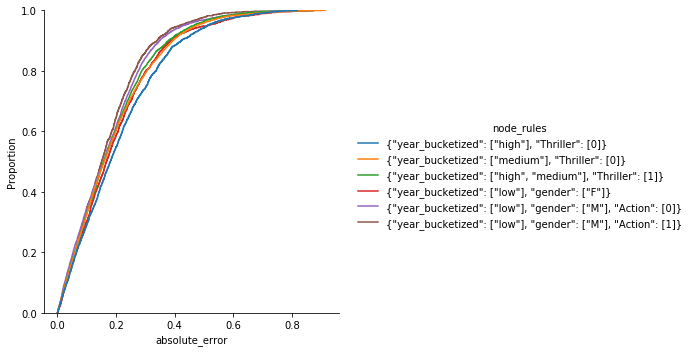

In [7]:
bias_tree_test = get_metric_bias_tree_for_model(model, X_test, data.attributes_dict, 
                                                 metric_name=METRIC,
                                                min_child_node_size=MIN_CHILD_NODE_SIZE)
bias_tree_test.leaf_metrics

Show the node with highest error

In [8]:
print(bias_tree_test.max_metric_node, round(bias_tree_test.max_metric_value, 3))

{"year_bucketized": ["high"], "Thriller": [0]} 0.209


### Retrain the model on the most biased node

Train on 7167 samples, validate on 2398 samples
Epoch 1/10
7167/7167 [==============================] - 0s 31us/sample - loss: 0.6230 - val_loss: 0.6349
Epoch 2/10
7167/7167 [==============================] - 0s 31us/sample - loss: 0.6223 - val_loss: 0.6340
Epoch 3/10
7167/7167 [==============================] - 0s 32us/sample - loss: 0.6210 - val_loss: 0.6344
Epoch 4/10
7167/7167 [==============================] - 0s 31us/sample - loss: 0.6208 - val_loss: 0.6343
Epoch 5/10
7167/7167 [==============================] - 0s 33us/sample - loss: 0.6198 - val_loss: 0.6336
Epoch 6/10
7167/7167 [==============================] - 0s 32us/sample - loss: 0.6196 - val_loss: 0.6342
Epoch 7/10
7167/7167 [==============================] - 0s 44us/sample - loss: 0.6182 - val_loss: 0.6338
Epoch 8/10
7167/7167 [==============================] - 0s 35us/sample - loss: 0.6175 - val_loss: 0.6345
Epoch 9/10
7167/7167 [==============================] - 0s 33us/sample - loss: 0.6174 - val_loss: 0.6334
Epoch 1

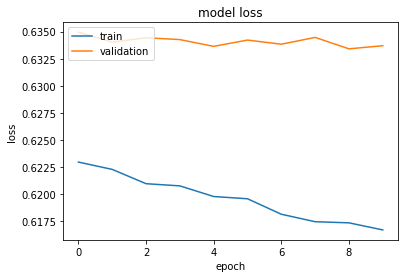

root=[]: 0.19
├── year_bucketized=['high', 'medium']: 0.193
│   ├── Thriller=[0]: 0.195
│   │   ├── year_bucketized=['high']: 0.208
│   │   └── year_bucketized=['medium']: 0.191
│   └── Thriller=[1]: 0.187
└── year_bucketized=['low']: 0.182
    ├── gender=['F']: 0.198
    └── gender=['M']: 0.178
        ├── Action=[0]: 0.18
        └── Action=[1]: 0.172



,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""year_bucketized"": [""low""], ""gender"": [""M""], ""Action"": [1]}",1414.0,0.172092,0.129213,0.000080,0.072705,0.149485,0.239047,0.877049
"{""year_bucketized"": [""low""], ""gender"": [""M""], ""Action"": [0]}",3787.0,0.179678,0.137807,0.000032,0.071364,0.157720,0.254568,0.839913
"{""year_bucketized"": [""high"", ""medium""], ""Thriller"": [1]}",3259.0,0.187205,0.142113,0.000159,0.075555,0.158024,0.262588,0.877615
"{""year_bucketized"": [""medium""], ""Thriller"": [0]}",7633.0,0.191389,0.149706,0.000009,0.075800,0.158097,0.273424,0.919950
"{""year_bucketized"": [""low""], ""gender"": [""F""]}",1593.0,0.197873,0.154172,0.000074,0.080816,0.166001,0.276693,0.885434
"{""year_bucketized"": [""high""], ""Thriller"": [0]}",2314.0,0.207824,0.156393,0.000229,0.082922,0.180651,0.297567,0.823330


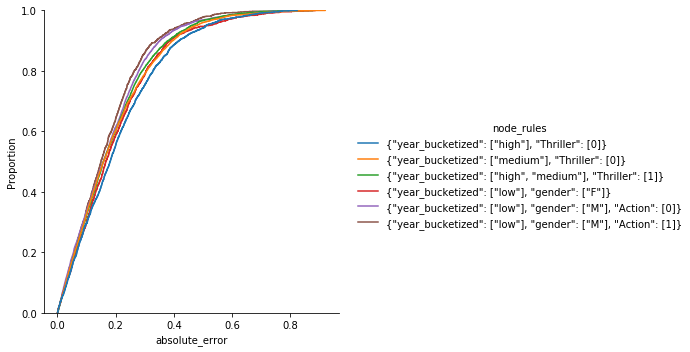

In [9]:
X_train_filtered = bias_tree_test.get_filtered_df(bias_tree_test.max_metric_node,  X_train)
X_val_filtered = bias_tree_test.get_filtered_df(bias_tree_test.max_metric_node,  X_val)

model_bias = retrain_recommendation_model(X_train_filtered, X_val_filtered, model=model, epochs=10)
bias_tree_test_retrained = get_metric_bias_tree_for_model(model_bias, X_test, data.attributes_dict, 
                                                 metric_name=METRIC, min_child_node_size=MIN_CHILD_NODE_SIZE,)
display(bias_tree_test_retrained.leaf_metrics)

In [10]:
node_metric_after_retraining = bias_tree_test_retrained.get_filtered_df('{"year_bucketized": ["low"], "gender": ["F"]}',  X_test)['absolute_error'].mean()
print(f'Diff in error for the most biased node:\n {bias_tree_test.max_metric_node}:\
      {round(100 * (node_metric_after_retraining - bias_tree_test.max_metric_value) / bias_tree_test.max_metric_value, 2)}%')

Diff in error for the most biased node:
 {"year_bucketized": ["high"], "Thriller": [0]}:      -5.36%
